In [1]:
import numpy as np
import pydot
import time
from IPython.display import SVG, display
from matplotlib import pyplot as plt
from pydrake.all import (
    Binding,
    DirectCollocation,
    DirectTranscription,
    GraphOfConvexSets,
    GraphOfConvexSetsOptions,
    HPolyhedron,
    LinearConstraint,
    LinearSystem,
    MathematicalProgram,
    Point,
    eq,
    AddMultibodyPlantSceneGraph,
    BsplineTrajectory,
    CompositeTrajectory,
    PiecewisePolynomial,
    DiagramBuilder,
    KinematicTrajectoryOptimization,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    MinimumDistanceLowerBoundConstraint,
    Parser,
    PositionConstraint,
    Rgba,
    RigidTransform,
    Role,
    Solve,
    Sphere,
    StartMeshcat,
    SnoptSolver,
    SolverOptions,
    MultibodyPlant
)
from pydrake.systems.primitives import (
    ConstantVectorSource,
    Multiplexer,
    PassThrough,
)
from manipulation.meshcat_utils import PublishPositionTrajectory
from manipulation.scenarios import AddIiwa, AddPlanarIiwa, AddWsg
from manipulation.utils import ConfigureParser

The plant is discrete
plant number of position and velocity: 3 3
num input ports:  14
geometry_query PortDataType.kAbstractValued
actuation PortDataType.kVectorValued
applied_generalized_force PortDataType.kVectorValued
applied_spatial_force PortDataType.kAbstractValued
WorldModelInstance_actuation PortDataType.kVectorValued
WorldModelInstance_desired_state PortDataType.kVectorValued
DefaultModelInstance_actuation PortDataType.kVectorValued
DefaultModelInstance_desired_state PortDataType.kVectorValued
iiwa14_actuation PortDataType.kVectorValued
iiwa14_desired_state PortDataType.kVectorValued
gripper_actuation PortDataType.kVectorValued
gripper_desired_state PortDataType.kVectorValued
shelves_actuation PortDataType.kVectorValued
shelves_desired_state PortDataType.kVectorValued
diagram systems:


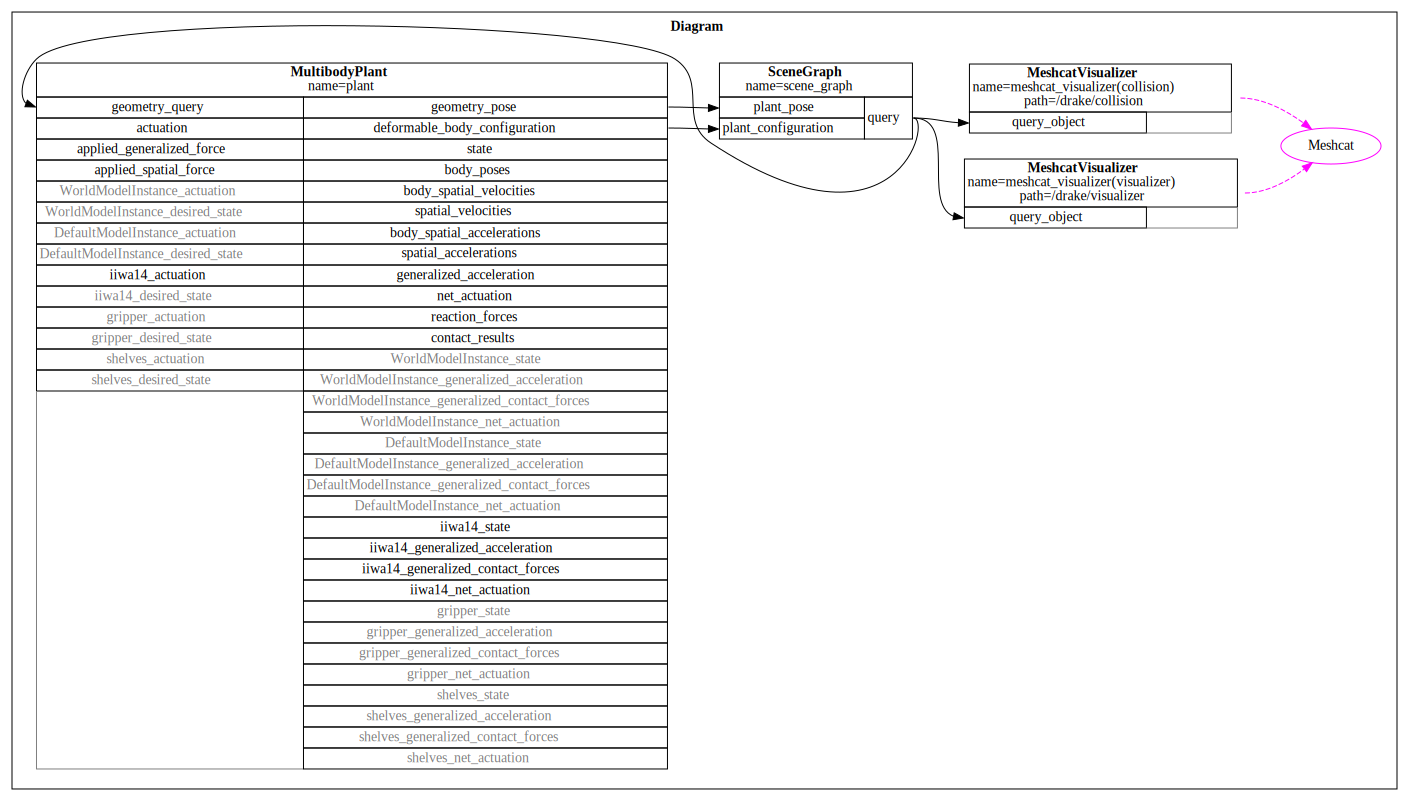

plant topology:


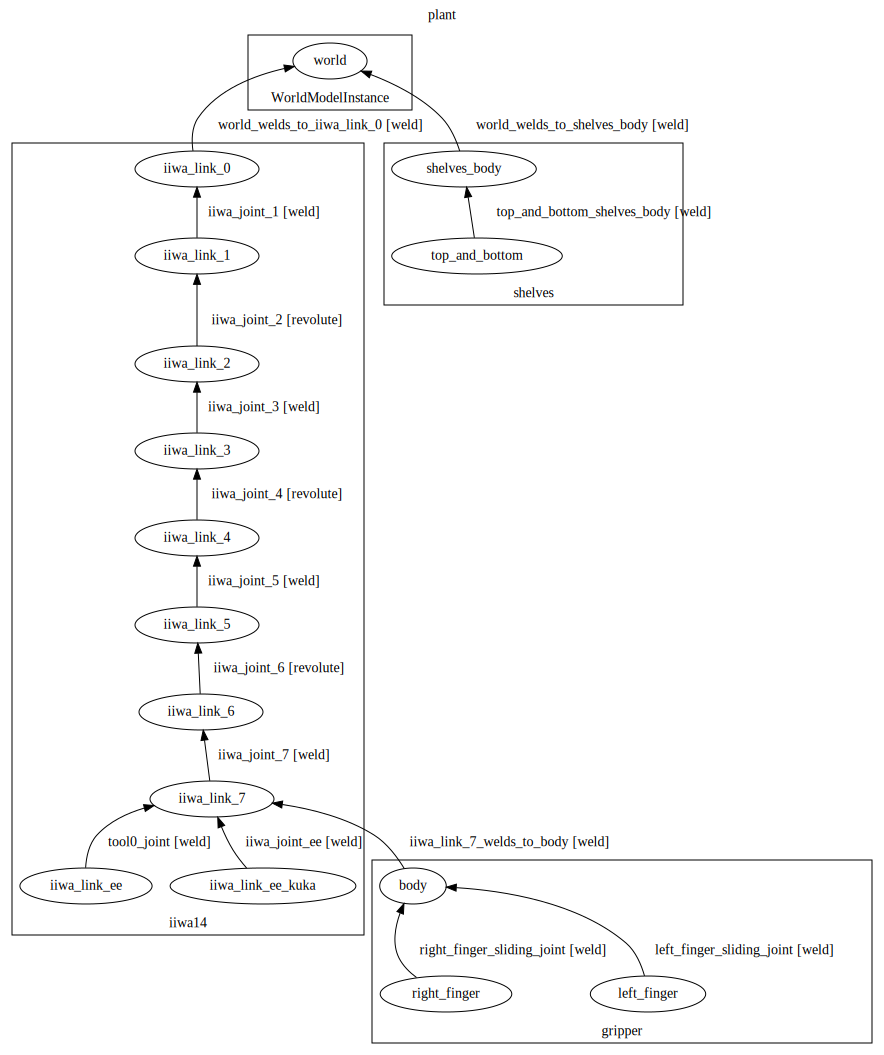

RuntimeError: DirectTranscription cannot operate on systems with abstract state. (For a MultibodyPlant, set its use_sampled_output_ports config option to false to remove the unwanted abstract state.)

In [15]:
# we are saying DirectTranscription can not work with abastrac prot. Then does that mean it can ont 
# work with any multibody?
# abstracport to calcualte collision or contact

def dirtran_example():
    meshcat = StartMeshcat()
    meshcat.Delete()

    builder = DiagramBuilder()

    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.01) # 0.0 time_step means continous
    
    iiwa = AddPlanarIiwa(plant)
    wsg = AddWsg(plant, iiwa, roll=0.0, welded=True, sphere=True)
    X_WStart = RigidTransform([0.8, 0, 0.65])
    meshcat.SetObject("start", Sphere(0.02), rgba=Rgba(0.9, 0.1, 0.1, 1))
    meshcat.SetTransform("start", X_WStart)
    X_WGoal = RigidTransform([0.8, 0, 0.4])
    meshcat.SetObject("goal", Sphere(0.02), rgba=Rgba(0.1, 0.9, 0.1, 1))
    meshcat.SetTransform("goal", X_WGoal)

    assert plant.geometry_source_is_registered()

    parser = Parser(plant)
    ConfigureParser(parser)
    bin = parser.AddModelsFromUrl("package://manipulation/shelves.sdf")[0]
    plant.WeldFrames(
        plant.world_frame(),
        plant.GetFrameByName("shelves_body", bin),
        RigidTransform([0.88, 0, 0.4]),
    )
    
    if plant.time_step() > 0:
       print('The plant is discrete')
    else:
       print('The plant is continuous')

    # For a continuous-time plant, there is no distinction – the output port is always live – it immediately 
    # reflects the instantaneous input value
    # For a discrete-time plannt, 
    #           State related outputs (states, body_poses, body_spatial_velocity) are always live
    #           For force related outputs (all other outputs other than the three aboeve) the user can choose 
    #           whether the output should be:
    #               sampled (a snapshot of the acceleration that was used in the last time step) or
    #               live (recalculate the acceleration to immediately reflect the changing forces in the current time step)
    plant.SetUseSampledOutputPorts(True)

    plant.Finalize()

    # should we connect a constant value source to the actuation?
    # controller = builder.AddSystem(ConstantVectorSource(np.zeros(3)))
    # builder.Connect(
    #         controller.get_output_port(),
    #         plant.get_actuation_input_port())

    visualizer = MeshcatVisualizer.AddToBuilder(
        builder,
        scene_graph,
        meshcat,
        MeshcatVisualizerParams(role=Role.kIllustration),
    )
    collision_visualizer = MeshcatVisualizer.AddToBuilder(
        builder,
        scene_graph,
        meshcat,
        MeshcatVisualizerParams(
            prefix="collision", role=Role.kProximity, visible_by_default=False
        ),
    )

    diagram = builder.Build()
    diagram_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(diagram_context)

    num_q = plant.num_positions()
    print('plant number of position and velocity:', plant.num_positions(), plant.num_velocities())
    # q0 = plant.GetPositions(plant_context)
    gripper_frame = plant.GetFrameByName("body", wsg)

    N = 100
    q0 = [0.40236988, -1.36484125, 0.01485271, 0.0, 0.0, 0.0]
    qf = [0.25544649, -1.87551969, -0.49582573, 0.0, 0.0, 0.0]

    # Set default positions:
    # q0 = [0.1, -1.2, 1.6]
    # index = 0
    # for joint_index in plant.GetJointIndices(iiwa):
    #     joint = plant.get_mutable_joint(joint_index)
    #     if isinstance(joint, RevoluteJoint):
    #         joint.set_default_angle(q0[index])
    #         index += 1

    print('num input ports: ', plant.num_input_ports())
    for index in range(plant.num_input_ports()):
        port = plant.get_input_port(index)
        print(port.get_name(), port.get_data_type())
    
    print('diagram systems:')
    display(
        SVG(
                pydot.graph_from_dot_data(diagram.GetGraphvizString ())[0].create_svg()
            )
    )
    print('plant topology:')
    display(
        SVG(
            pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_svg()
        )
    )

    # --- discrete
    dirtran = DirectTranscription(  
        plant, 
        plant_context, 
        N,
        input_port_index = plant.get_actuation_input_port().get_index()
    )
    #  --- Contineous
    # dirtran = DirectTranscription(  
    #     plant, 
    #     plant_context, 
    #     N,
    #     fixed_time_step=DirectTranscription.TimeStep(0.1),
    #     input_port_index = plant.get_actuation_input_port().get_index()
    # )
    # --- diagram
    # dirtran = DirectTranscription(  
    #     diagram, 
    #     diagram_context, 
    #     N,
    # )
    prog = dirtran.prog()
    print(prog.num_vars())
    print('decision variables:', prog.decision_variables())
    print(dirtran.initial_state().shape)
    # boundary conditions
    prog.AddBoundingBoxConstraint(q0, q0, dirtran.initial_state())
    prog.AddBoundingBoxConstraint(qf, qf, dirtran.final_state())
    dirtran.AddConstraintToAllKnotPoints(dirtran.input()[0] <= 1)
    dirtran.AddConstraintToAllKnotPoints(dirtran.input()[0] >= -1)
    dirtran.AddRunningCost(dirtran.input()[0] ** 2)

    # initial solution
    initial_u = PiecewisePolynomial.ZeroOrderHold([0, 0.3*21],
                                                      np.zeros((1, 2)))
    initial_x = PiecewisePolynomial()
    dirtran.SetInitialTrajectory(initial_u, initial_x)

    # result = Solve(prog, None, None)

    solver = SnoptSolver()
    solver_options = SolverOptions()
    result = solver.Solve(prog, None, solver_options)

    # assert result.is_success(), "Optimization failed"

    # PublishPositionTrajectory(
    #     dirtran.ReconstructTrajectory(result), diagram_context, plant_context, visualizer
    # )

    # u_sol = dirtran.ReconstructInputTrajectory(result)
    # x_sol = dirtran.ReconstructStateTrajectory(result)

    # fig, ax = plt.subplots(2, 1)
    # x_values = x_sol.vector_values(x_sol.get_segment_times())
    # ax[0].plot(x_values[0, :], x_values[1, :], "-")
    # ax[0].set_xlabel("q")
    # ax[0].set_ylabel("qdot")

    # u_values = u_sol.vector_values(u_sol.get_segment_times())
    # ax[1].plot(u_sol.get_segment_times(), u_values.T, "-")
    # ax[1].set_xlabel("t")
    # ax[1].set_ylabel("u")


dirtran_example()

# Only one system.
No Builder. We do not want scene graph to be present. Because as the error Above says, the DirectTranscription can not operate on systems with abstract state. SceneGraph comes with abstrac state. So lets have only one component which is a multibodyplant


In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7002


diagram systems:


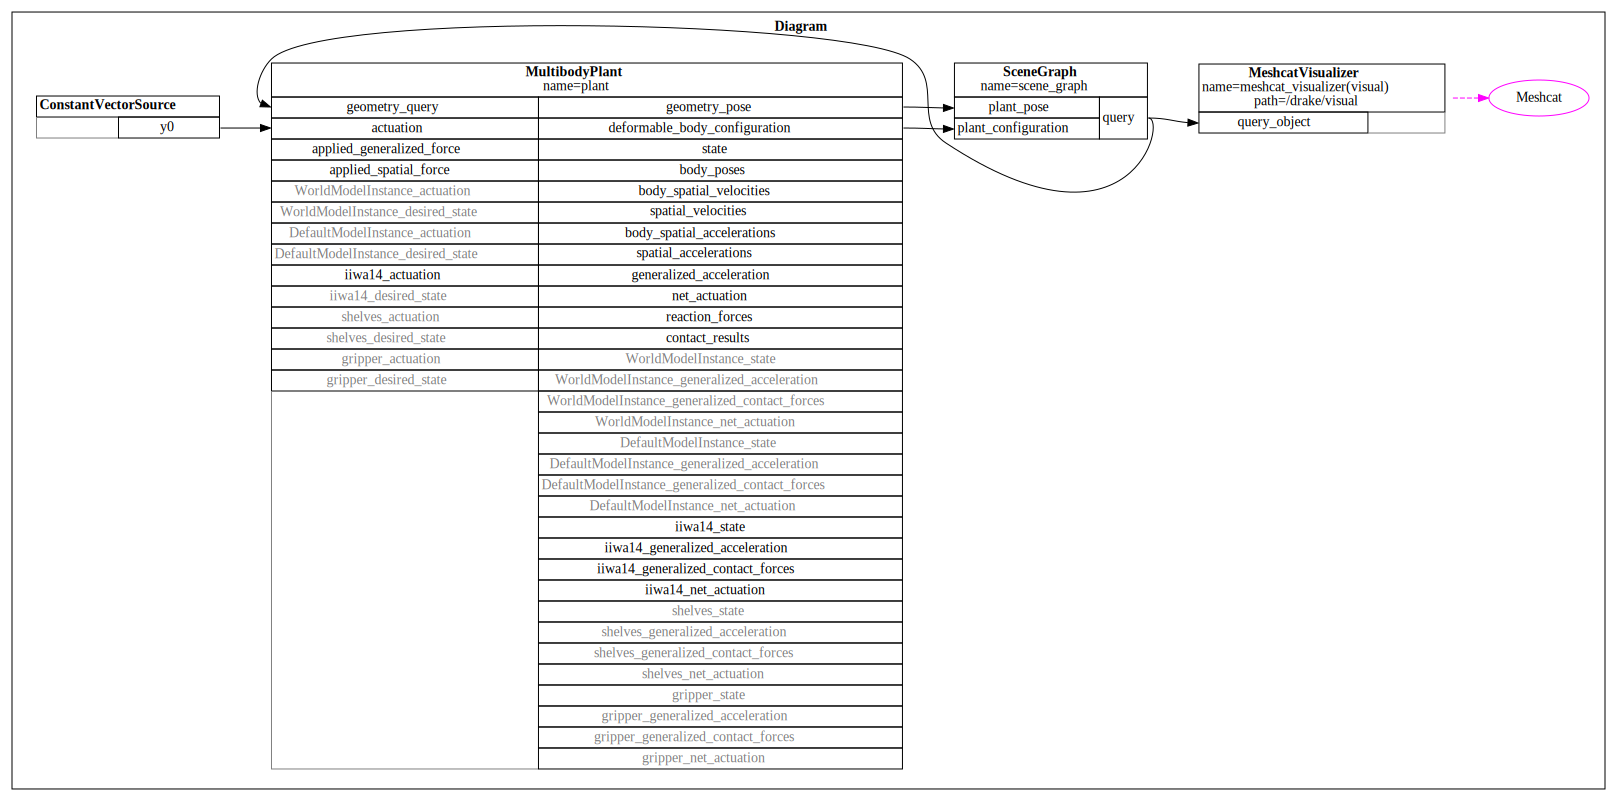

The plant is discrete
plant number of position and velocity: 3 3
num input ports:  10
geometry_query PortDataType.kAbstractValued
actuation PortDataType.kVectorValued
applied_generalized_force PortDataType.kVectorValued
applied_spatial_force PortDataType.kAbstractValued
WorldModelInstance_actuation PortDataType.kVectorValued
WorldModelInstance_desired_state PortDataType.kVectorValued
DefaultModelInstance_actuation PortDataType.kVectorValued
DefaultModelInstance_desired_state PortDataType.kVectorValued
iiwa14_actuation PortDataType.kVectorValued
iiwa14_desired_state PortDataType.kVectorValued
plant topology:


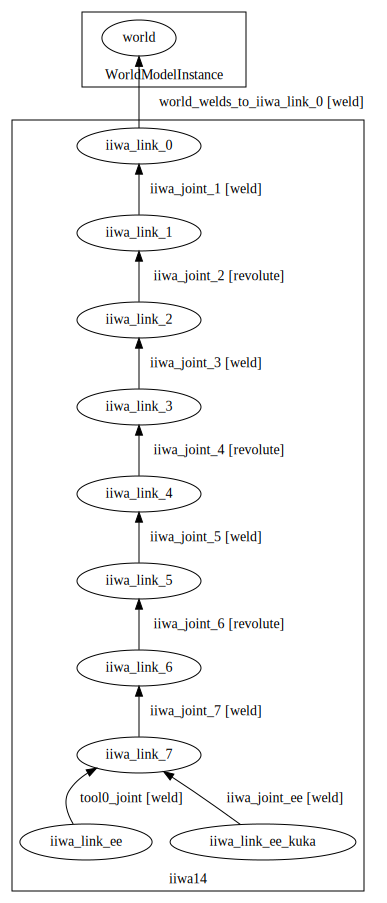

900
(6,)
successful optimiztion
optimal cost:  2.3526364211176575e-14
(900,)


In [4]:
# we are saying DirectTranscription can not work with abastrac prot. Then does that mean it can ont 
# work with any multibody?
# abstracport to calcualte collision or contact

def dirtran_example():
    meshcat.Delete()
    
    ##########################
    # visualization plant
    ##########################
    builder = DiagramBuilder()
    dt = 0.01
    # this plant is for visualization
    plant_vis, scene_graph = AddMultibodyPlantSceneGraph(builder, dt)
    parser = Parser(plant_vis)
    iiwa = parser.AddModelsFromUrl(
        "package://drake_models/iiwa_description/urdf/planar_iiwa14_spheres_dense_elbow_collision.urdf"
    )[0]
    plant_vis.WeldFrames(plant_vis.world_frame(), plant_vis.GetFrameByName("iiwa_link_0"))
    
    assert plant_vis.geometry_source_is_registered()

    parser = Parser(plant_vis)
    bin = parser.AddModelsFromUrl("file:///home/omid/drake/note/shelves.sdf")[0]
    plant_vis.WeldFrames(
        plant_vis.world_frame(),
        plant_vis.GetFrameByName("shelves_body", bin),
        RigidTransform([0.88, 0, 0.4]),
    )

    wsg = AddWsg(plant_vis, iiwa, roll=0.0, welded=True, sphere=True)
    X_WStart = RigidTransform([0.8, 0, 0.65])
    meshcat.SetObject("start", Sphere(0.02), rgba=Rgba(0.9, 0.1, 0.1, 1))
    meshcat.SetTransform("start", X_WStart)
    X_WGoal = RigidTransform([0.8, 0, 0.4])
    meshcat.SetObject("goal", Sphere(0.02), rgba=Rgba(0.1, 0.9, 0.1, 1))
    meshcat.SetTransform("goal", X_WGoal)

    gripper_frame = plant_vis.GetFrameByName("body", wsg)

    plant_vis.Finalize()

    # should we connect a constant value source to the actuation?
    controller = builder.AddSystem(ConstantVectorSource(np.zeros(3)))
    builder.Connect(
            controller.get_output_port(),
            plant_vis.get_actuation_input_port())

    visualizer = MeshcatVisualizer.AddToBuilder( 
        builder, scene_graph, meshcat,
        MeshcatVisualizerParams(role=Role.kPerception, prefix="visual")
    )
    # what is this?
    # DrakeVisualizer().AddToBuilder(builder, scene_graph)
    # ConnectContactResultsToDrakeVisualizer(builder, plant_vis, scene_graph)

    # collision_visualizer = MeshcatVisualizer.AddToBuilder(
    #     builder,
    #     scene_graph,
    #     meshcat,
    #     MeshcatVisualizerParams(
    #         prefix="collision", role=Role.kProximity, visible_by_default=False
    #     ),
    # )


    diagram = builder.Build()
    diagram_context = diagram.CreateDefaultContext()
    plant_vis_context = diagram.GetMutableSubsystemContext(plant_vis, diagram_context)

    print('diagram systems:')
    display(
        SVG(
                pydot.graph_from_dot_data(diagram.GetGraphvizString ())[0].create_svg()
            )
    )
    
    ##########################
    # optimization plant
    ##########################
    # the plant to be used in the DirectTranscription optimization method
    plant = MultibodyPlant(dt)
    parser = Parser(plant)
    iiwa = parser.AddModelsFromUrl(
        "package://drake_models/iiwa_description/urdf/planar_iiwa14_spheres_dense_elbow_collision.urdf"
    )[0]
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0"))
    # For a continuous-time plant, there is no distinction – the output port is always live – it immediately 
    # reflects the instantaneous input value
    # For a discrete-time plannt, 
    #           State related outputs (states, body_poses, body_spatial_velocity) are always live
    #           For force related outputs (all other outputs other than the three aboeve) the user can choose 
    #           whether the output should be:
    #               sampled (a snapshot of the acceleration that was used in the last time step) or
    #               live (recalculate the acceleration to immediately reflect the changing forces in the current time step)
    plant.SetUseSampledOutputPorts(False)
    plant.Finalize()
    
    if plant.time_step() > 0:
       print('The plant is discrete')
    else:
       print('The plant is continuous')

    plant_context = plant.CreateDefaultContext()
    
    num_q = plant.num_positions()
    print('plant number of position and velocity:', plant.num_positions(), plant.num_velocities())
    # q0 = plant.GetPositions(plant_context)

    N = 100
    q0 = [0.40236988, -1.36484125, 0.01485271, 0.0, 0.0, 0.0]
    qf = [0.25544649, -1.87551969, -0.49582573, 0.0, 0.0, 0.0]

    # Set default positions:
    # q0 = [0.1, -1.2, 1.6]
    # index = 0
    # for joint_index in plant.GetJointIndices(iiwa):
    #     joint = plant.get_mutable_joint(joint_index)
    #     if isinstance(joint, RevoluteJoint):
    #         joint.set_default_angle(q0[index])
    #         index += 1

    print('num input ports: ', plant.num_input_ports())
    for index in range(plant.num_input_ports()):
        port = plant.get_input_port(index)
        print(port.get_name(), port.get_data_type())
    
    print('plant topology:')
    display(
        SVG(
            pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_svg()
        )
    )

    # --- discrete
    dirtran = DirectTranscription(  
        plant, 
        plant_context, 
        N,
        input_port_index = plant.get_actuation_input_port().get_index()
    )
    
    #  --- Contineous
    # dirtran = DirectTranscription(  
    #     plant, 
    #     plant_context, 
    #     N,
    #     fixed_time_step=DirectTranscription.TimeStep(0.1),
    #     input_port_index = plant.get_actuation_input_port().get_index()
    # )
    # --- diagram
    # dirtran = DirectTranscription(  
    #     diagram, 
    #     diagram_context, 
    #     N,
    # )
    prog = dirtran.prog()
    print(prog.num_vars())
    # print('decision variables:', prog.decision_variables())
    print(dirtran.initial_state().shape)
    # boundary conditions
    prog.AddBoundingBoxConstraint(q0, q0, dirtran.initial_state())
    prog.AddBoundingBoxConstraint(qf, qf, dirtran.final_state())
    dirtran.AddConstraintToAllKnotPoints(dirtran.input()[0] <= 1)
    dirtran.AddConstraintToAllKnotPoints(dirtran.input()[0] >= -1)
    dirtran.AddRunningCost(dirtran.input()[0] ** 2)

    # initial solution
    initial_u = PiecewisePolynomial.ZeroOrderHold([0, 0.3*21],
                                                      np.zeros((1, 2)))
    initial_x = PiecewisePolynomial()
    dirtran.SetInitialTrajectory(initial_u, initial_x)

    # result = Solve(prog, None, None)

    solver = SnoptSolver()
    solver_options = SolverOptions()
    result = solver.Solve(prog, None, solver_options)

    if not result.is_success():
        "Optimization failed"

    print('successful optimiztion')
    print('optimal cost: ', result.get_optimal_cost())
    print(result.GetSolution().shape)

    # PublishPositionTrajectory(
    #     dirtran.ReconstructStateTrajectory(result), diagram_context, plant_vis, visualizer
    # )

    # Extract the solution
    timesteps = dirtran.GetSampleTimes(result)
    states = dirtran.GetStateSamples(result)
    inputs = dirtran.GetInputSamples(result)
    while True:
        # Just keep playing back the trajectory
        for i in range(len(timesteps)):
            t = timesteps[i]
            x = states[:,i]

            diagram_context.SetTime(t)
            plant_vis.SetPositionsAndVelocities(plant_vis_context, x)
            diagram.ForcedPublish(diagram_context)

            time.sleep(dt-3e-3)
        time.sleep(1)

    


dirtran_example()